<a href="https://colab.research.google.com/github/Fen-ryx/Video-Super-Resolution-Project/blob/Code-Templates/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import statements
!pip install -q sklearn

%tensorflow_version 2.x

import os
import sys

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from six.moves import urllib

In [2]:
# Load Dataset
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = df_train.pop('survived')
y_eval = df_eval.pop('survived')

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


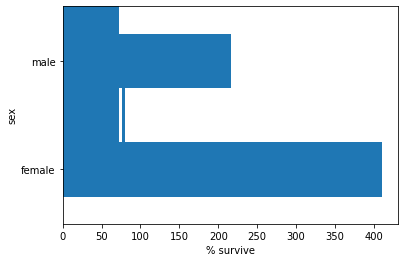

In [3]:
# Useful commands to visualize and understand the data
df_train.head()
df_train.describe()
df_train.shape
y_train.head()
df_train.age.hist(bins = 20)
df_train.sex.value_counts().plot(kind = 'barh')
df_train['class'].value_counts().plot(kind = 'barh')
pd.concat([df_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
df_train.head() # to confirm that the concat function does not concatenate into df_train

In [4]:
Categorical_Columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
Numerical_Columns = ['age', 'fare']

feature_columns = []
for feature in Categorical_Columns:
    vocabulary = df_train[feature].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocabulary))

for feature in Numerical_Columns:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype = tf.float32))

print (feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [5]:
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [6]:
train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_eval, y_eval, num_epochs = 1, shuffle = False)

In [7]:
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpd5jl572v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

0.7689394


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpd5jl572v/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


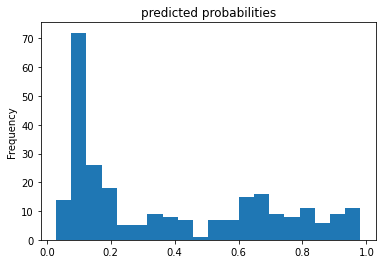

In [9]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind = 'hist', bins = 20, title = 'predicted probabilities')